In [6]:
# %load sim_visibility.py
import numpy as np, itertools, os
import cupy as cp
import itertools
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tools21cm as t2c

import astropy.units as u
import astropy.constants as cst

from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time
from tqdm import tqdm

In [7]:
# define a 2D gaussian function
def gaussian_2d(prefactor, x, y, mean, cov):
    """ a simple 2D gaussian distribution """
    x_diff = x - mean[0]
    y_diff = y - mean[1]
    inv_cov = np.linalg.inv(cov)
    exponent = -0.5 * (x_diff**2 * inv_cov[0, 0] + y_diff**2 * inv_cov[1, 1] + 2 * x_diff * y_diff * inv_cov[0, 1])
    return prefactor * np.exp(exponent)

def galactic_synch_fg_custom(z, ncells, boxsize, rseed=False):
    if(isinstance(z, float)):
        z = np.array([z])
    else:
        z = np.array(z, copy=False)
    gf_data = np.zeros((ncells, ncells, z.size))

    if(rseed): np.random.seed(rseed)
    X  = np.random.normal(size=(ncells, ncells))
    Y  = np.random.normal(size=(ncells, ncells))
    nu_s,A150,beta_,a_syn,Da_syn = 150,513,2.34,2.8,0.1

    for i in range(0, z.size):
        nu = t2c.cosmo.z_to_nu(z[i])
        U_cb  = (np.mgrid[-ncells/2:ncells/2,-ncells/2:ncells/2]+0.5)*t2c.cosmo.z_to_cdist(z[i])/boxsize
        l_cb  = 2*np.pi*np.sqrt(U_cb[0,:,:]**2+U_cb[1,:,:]**2)
        #C_syn = A150*(1000/l_cb)**beta_*(nu/nu_s)**(-2*a_syn-2*Da_syn*np.log(nu/nu_s))
        C_syn = A150*(1000/l_cb)**beta_
        #C_syn = A150
        solid_angle = boxsize**2/t2c.cosmo.z_to_cdist(z[i])**2
        AA = np.sqrt(solid_angle*C_syn/2)
        T_four = AA*(X+Y*1j) * np.sqrt(2)
        T_real = np.abs(np.fft.ifft2(T_four))   #in Jansky
        #gf_data[..., i] = t2c.jansky_2_kelvin(T_real*1e6, z[i], boxsize=boxsize, ncells=ncells)
        gf_data[..., i] = T_real
    return gf_data.squeeze()


def vectorized_visibility_computation(uvw, sky_coord, freq, I_sky, beam_pattern, max_norm, chunk_size):
    # Convert to CuPy arrays
    uvw = cp.asarray(uvw)
    sky_coord = cp.asarray(sky_coord)
    I_sky = cp.asarray(I_sky)
    beam_pattern = cp.asarray(beam_pattern)
    
    l_coord, m_coord = cp.meshgrid(sky_coord, sky_coord)
    
    uvw_norms = cp.linalg.norm(uvw, axis=1)
    
    if max_norm is not None:
        valid_uvw_ids = cp.where(uvw_norms < max_norm)[0]
        filter_uvw = uvw[valid_uvw_ids]
        filter_uvw_norms = uvw_norms[valid_uvw_ids]
    else:
        valid_uvw_ids = cp.arange(len(uvw))
        filter_uvw = uvw
        filter_uvw_norms = uvw_norms
    
    l_coord = l_coord.flatten()
    m_coord = m_coord.flatten()
    I_sky = I_sky.flatten()
    beam_pattern = beam_pattern.flatten()
    
    visibility_list = cp.empty(len(valid_uvw_ids), dtype = cp.complex128)
    
    # Process in chunks
    for start in range(0, len(valid_uvw_ids), chunk_size):
        end = min(start + chunk_size, len(valid_uvw_ids))
        chunk_uvw = filter_uvw[start:end]
        
        fringe = cp.exp(-2j * cp.pi * (chunk_uvw[:,0,None] * l_coord + chunk_uvw[:,1,None] * m_coord))
        vis_chunk = cp.dot(fringe, I_sky * beam_pattern)
        visibility_list[start:end] = vis_chunk
    
    return cp.asnumpy(visibility_list), cp.asnumpy(cp.max(filter_uvw_norms))


def process_timesteps(uvw, start_timestep, end_timestep, file_path, sky_coord, freq, I_sky, beam_pattern, max_norm, chunk_size):
    # empty visibilities
    visibilities = []
    processed_timesteps = set()

    # Load existing data if the file exists
    if os.path.exists(file_path):
        existing_uvw = np.load(file_path)
        existing_timesteps = existing_uvw.shape[0]
        processed_timesteps.update(range(existing_timesteps))
    else:
        existing_uvw = None

    # loop over timesteps
    for t in tqdm(range(start_timestep, end_timestep), desc='Calculate visibility: '):
        visls, max_uvw = vectorized_visibility_computation(uvw[t], sky_coord, freq, I_sky, beam_pattern, max_norm, chunk_size)
        visibilities.append(visls)
    
    if visibilities:
        visibilities = np.array(visibilities)  # Shape will be (new_timesteps, 130816)
        
        if existing_uvw is not None:
            visibilities = np.concatenate((existing_uvw, visibilities), axis=0)
        
        #np.save(file_path, visibilities)
        print(f"Processed and stored visibility for timesteps {start_timestep} to {end_timestep - 1}.")
    else:
        print(f"No new timesteps to process between {start_timestep} and {end_timestep}.")
    return visibilities


# define ratation matrix
def Earth_Rotation_Effect(HA, delta):
    HA, delta = HA.to('rad'), delta.to('rad')
    return np.array([[np.sin(HA), np.cos(HA), 0], 
                     [-np.sin(delta)*np.cos(HA), np.sin(delta)*np.sin(HA), np.cos(delta)],
                     [np.cos(delta)*np.cos(HA), -np.cos(delta)*np.sin(HA), np.sin(delta)]])


In [11]:
print('------ Define Telescope ------')
# Loading the telescope and station layout coords:
#telescope_layout = np.loadtxt('skalow_AA4_layout.txt') * u.m
telescope_layout = np.loadtxt('skalow_AA1_layout.txt') * u.m
station_layout = np.loadtxt('station_layout.txt') * u.m

N_ant = telescope_layout.shape[0]
N_B = int(N_ant*(N_ant-1)/2)

freq = 166. * u.MHz
lam = (cst.c / freq).to('m')
z = 1.42*u.GHz/freq - 1.
print(' frequency [MHz]:', freq)
print(' wavelength [m]:', lam)
print(' redshift:', z)

# get pair of baselines
pair_comb = list(itertools.combinations(range(N_ant), 2))

assert np.shape(pair_comb)[0] == N_B

uv_coord = np.empty((N_B, telescope_layout.shape[1]))
for i in tqdm(range(N_B), desc='Calculate baselines: '):
    ii, jj = pair_comb[i]
    
    # calculate the distance between antennas
    uv_coord[i] = (telescope_layout[ii] - telescope_layout[jj])/lam

# sort by increasing baseline distance
uv_length = np.linalg.norm(uv_coord.squeeze(), axis=1)
idx_sort = np.argsort(uv_length)
pair_comb = np.array(pair_comb)[idx_sort]
uv_coord = uv_coord.squeeze()[idx_sort]

# add time axis TODO: now is just one timestep
uv_coord = uv_coord[None,...]

------ Define Telescope ------
 frequency [MHz]: 166.0 MHz
 wavelength [m]: 1.8059786626506023 m
 redshift: 7.554216867469879


Calculate baselines: 100%|█████████████████| 120/120 [00:00<00:00, 29061.52it/s]


In [12]:
# Declination
dec = -30. * u.deg

# integration time
int_time = (10.*u.s).to('h')

# Radial angle, Hour angle window
h_angle = np.arange(-2, 2, int_time.value) * u.hourangle

time_steps = h_angle.size
t_obs = h_angle.max()-h_angle.min()

print('Observation length :', t_obs)
print('Integration time :', )
print('Number of time steps : ', time_steps)

Observation length : 3.997222222222208 hourangle
Integration time :
Number of time steps :  1440


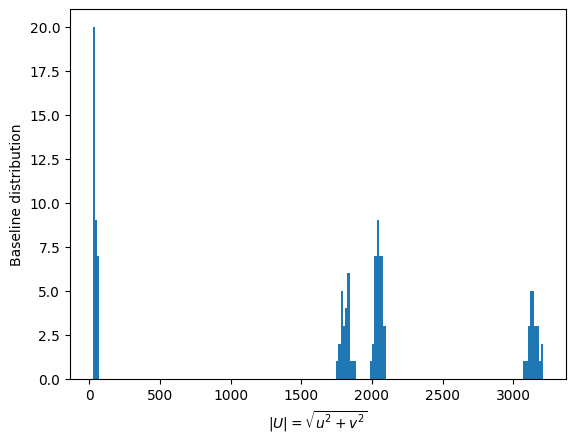

In [13]:
plt.hist(uv_length, bins=200);
plt.xlabel(r'$|U| = \sqrt{u^2 + v^2}$'), plt.ylabel('Baseline distribution')
plt.show()

In [26]:
print('------ Antenna Parameters ------')
D = np.linalg.norm(station_layout, axis=1).max()*2
print(' dish diameter [m]:', D)

theta_fwhm = (1.03 * lam / D) * u.rad
theta_0 = 0.6 * theta_fwhm
V_0 = (np.pi * theta_0**2 / 2).to('sr')
N_pix = 256
print(' theta_fwhm:', theta_fwhm)
print(' theta_0:', theta_0)
print(' V_0:', V_0)

print('\n------ Observational Quantities ------')
FoV = np.sqrt(V_0).to('rad')
L_box = FoV.to('rad').value * (1+z)*cosmo.angular_diameter_distance(z)
dthet = L_box / ((1+z)*cosmo.angular_diameter_distance(z)*N_pix) * u.rad
print(' FoV:', FoV)
print(' Boxsize:', L_box)
print(' dthet:', dthet)

#--------------------------------------------------
# define a 1D sky and get RA coordinate
thet = np.linspace(-FoV/2, FoV/2, N_pix).to('rad').value

# Create a grid of points (we ignore third dimension, i.e. n-axis)
l_coord, m_coord = np.meshgrid(thet, thet)
lmn_coord = np.dstack((l_coord, m_coord)).reshape(-1, 2)

# Create a beam pattern
beam_pattern = np.exp(-((l_coord**2 + m_coord**2) / theta_0.value**2))

visibility_file_path = 'test.npy'

# --------------- Define Sky Model ---------------
# Define parameters for the 2D Gaussian source
# Get the sky model
#dT_jy = gaussian_2d(prefactor=1e-3, x=l_coord, y=m_coord, mean=np.array([0.005, -0.004]), cov=np.array([[(8e-1*u.arcsec).to('rad').value, 0], [0, (1e-1*u.arcsec).to('rad').value]]))
dT_jy = galactic_synch_fg_custom(z=[z], ncells=N_pix, boxsize=L_box.value)
#dT_jy = np.random.normal(loc=1e-3, scale=1e-4, size=(N_pix, N_pix))/1e4

#dT_jy = galactic_synch_fg_custom(z=[z], ncells=N_pix, boxsize=L_box.value)
#dT_jy += np.random.normal(loc=1e-3, scale=1e-4, size=(N_pix, N_pix))/1e4


------ Antenna Parameters ------
 dish diameter [m]: 38.06656275525806 m
 theta_fwhm: 0.048865930829890346 rad
 theta_0: 0.029319558497934207 rad
 V_0: 0.0013503138730938376 sr

------ Observational Quantities ------
 FoV: 0.036746617165309754 rad
 Boxsize: 330.573531325587 Mpc
 dthet: 0.00014354147330199123 rad


In [27]:
#Running the function
vis = process_timesteps(uv_coord, 0, 1, visibility_file_path, thet, z, dT_jy, beam_pattern, None, 128)

Calculate visibility: 100%|███████████████████████| 1/1 [00:00<00:00, 53.53it/s]

Processed and stored visibility for timesteps 0 to 0.


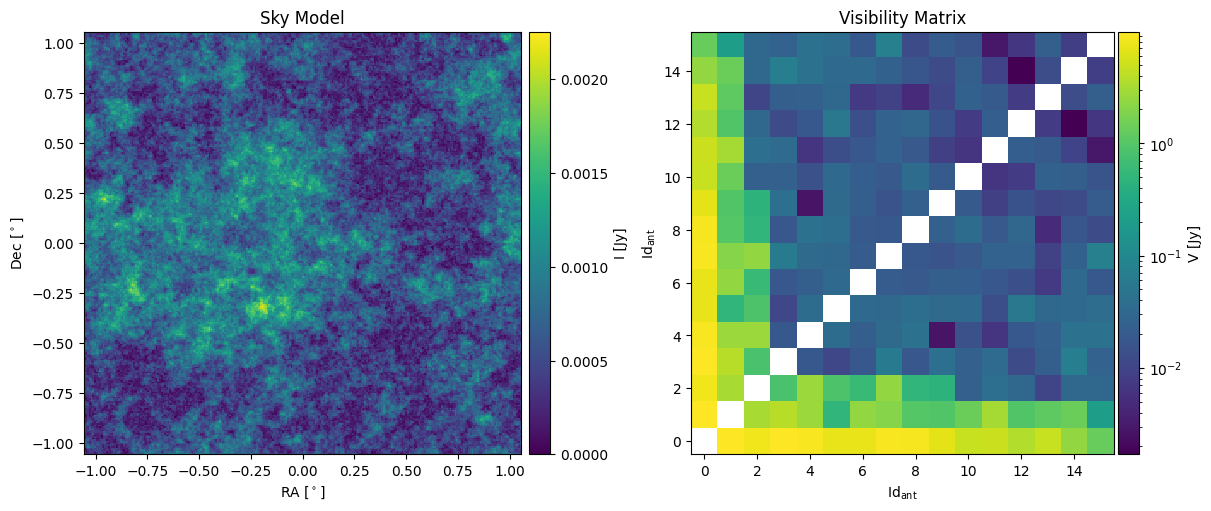

(None, None)

<Figure size 640x480 with 0 Axes>

In [28]:
# Define visibilities matrix
V_matrix = np.zeros((N_ant, N_ant))

pair_comb_sort = list(itertools.combinations(range(N_ant), 2))

for i_b in range(N_B):
    ii, jj = pair_comb_sort[i_b]

    # store visibility matrix
    V_matrix[ii, jj] = np.abs(vis[0, i_b])

# pairs are only for one corner
V_matrix = V_matrix + np.conj(V_matrix.T)

# plot visibility matrix
fig, axs = plt.subplots(figsize=(12, 5), ncols=2, nrows=1, constrained_layout=True)
axs[0].set_title('Sky Model')
#im = axs[0].pcolormesh((l_coord*u.rad).to('deg').value, (m_coord*u.rad).to('deg').value, dT_jy, vmin=0., vmax=0.002, cmap='viridis')
im = axs[0].pcolormesh((l_coord*u.rad).to('deg').value, (m_coord*u.rad).to('deg').value, dT_jy, vmin=0., cmap='viridis')
axs[0].set_xlabel(r'RA [$^\circ$]'), axs[0].set_ylabel(r'Dec [$^\circ$]')
plt.colorbar(im, ax=axs[0], label='I [Jy]', pad=0.01)

axs[1].set_title('Visibility Matrix')
im = axs[1].imshow(V_matrix, origin='lower', cmap='viridis', norm=LogNorm())
axs[1].set_xlabel(r'Id$_\mathrm{ant}$'), axs[1].set_ylabel(r'Id$_\mathrm{ant}$')
plt.colorbar(im, ax=axs[1], label='V [Jy]', pad=0.01)
plt.show(), plt.clf()